# Data Processing Notebook

In [1]:
import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import log_loss, classification_report,precision_recall_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample


SEED = 123

## 1. Reading Data

Raw data is scattered across 4 files:

`opp_data_updated.csv` - the raw data on opportunities
`output_data_fc.parquet`, `output_data_tc.parquet`, `output_data_fo.parquet`, `output_data_me.parquet` - the raw data on inbound, outbound, indirect communications, and meetings, respectively. 

The file (and variable) prefixes shall be read as follows: 
- `fc` - inbound email communications (From potential Customer)
- `tc` - outbound email communications (To potential Customer)
- `fo` - indirect email communications (From an Outside third party)
- `me` - synchronous communications (MEetings with potential customer)

In [2]:
opp_df = pd.read_csv('src/opp_data_updated.csv')

# convert time-related columns to appropriate data types
opp_df['CreatedDate'] = pd.to_datetime(pd.to_datetime(opp_df['CreatedDate']).dt.date)
opp_df['opp_estimated_close_date'] = pd.to_datetime(opp_df['opp_estimated_close_date'])
opp_df

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0061300001AC115AAD,2019-05-28,False,2014-09-23
1,0061300001AC115AAD,2019-05-28,False,2014-09-24
2,0061300001AC115AAD,2019-05-28,False,2014-10-02
3,0061300001AC115AAD,2019-05-28,False,2014-10-21
4,0061300001AC115AAD,2019-05-28,False,2014-10-24
...,...,...,...,...
27555,006Rp000000Z9mpIAC,2023-09-05,False,2023-08-22
27556,006Rp000000Z9mpIAC,2023-09-05,False,2023-08-23
27557,006Rp000000Z9mpIAC,2023-09-05,False,2023-08-31
27558,006Rp000000Z9mpIAC,2023-09-05,False,2023-09-05


Column description:
* `OpportunityId` - opportunity identificator
* `CreatedDate` - datetime of a new actiivty on the opportunity (typically describes some progress on the opportunity)
* `opp_esimated_close_date` - date of when the opportunity was finalized and closed
* `IsWon` - final status of the success on the opportunity. Can be `True` or `False`

To summarize, each row represents some action done on the opportunity at time `CreatedTime`. These rows are called stages.

Next step, we will change the meaning of the `CreatedDate` column by generating new stages for each day that opportunity existed before it closed. For this, we will iterate through each day where at least one opportunity exist and generate a fake stage for every opportunity that is open in that day.

In [3]:
unique_opps = opp_df.OpportunityId.nunique()
print(f"There are {unique_opps} unique opportunities in the data set")

There are 3822 unique opportunities in the data set


The following code cell drops duplicates since raw data contains the same oppotunities multiple times. Then, N rows are created for each opportunity where N stands for the number of days the opportunity was open. Each row represents the state of one opportunity on one day in its lifetime. We refer to any such row as opportunity-day.

In [4]:
# sort the table by created date and keep the first created date for each opportunity - it represents when the opportunity was created
opp_df = opp_df.sort_values('CreatedDate', ascending=True).drop_duplicates(subset=['OpportunityId'], keep='first')

start_date = opp_df.CreatedDate.min()
end_date = opp_df.opp_estimated_close_date.max()

total_datapoints = pd.DataFrame()

# iterate through each day of the total cycle and add stages for opportunities open on a certain date
for cur_date in tqdm(pd.date_range(start_date, end_date, freq='D', inclusive='both')):
    known = opp_df[(opp_df.CreatedDate < cur_date) & (cur_date <= opp_df.opp_estimated_close_date)]
    datapoints = known[['OpportunityId', 'opp_estimated_close_date', 'IsWon']].copy()
    datapoints['CreatedDate'] = cur_date
    total_datapoints = pd.concat([total_datapoints, datapoints], ignore_index=True)

opp_df = total_datapoints
opp_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4978/4978 [00:26<00:00, 189.62it/s]


,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0063000000YvrLnAAJ,2022-11-30,False,2010-01-23
1,0063000000YvrLnAAJ,2022-11-30,False,2010-01-24
2,0063000000YvrLnAAJ,2022-11-30,False,2010-01-25
3,0063000000YvrLnAAJ,2022-11-30,False,2010-01-26
4,0063000000YvrLnAAJ,2022-11-30,False,2010-01-27


In [5]:
print(f"Time Frame covered by the Opportunities Table: {opp_df.CreatedDate.min()} - {opp_df.CreatedDate.max()}")

Time Frame covered by the Opportunities Table: 2010-01-23 00:00:00 - 2023-09-08 00:00:00


The opportunities table covers the span of 13 years of opportunities. Now, let's take a look at the communications tables.

In [6]:
# read incoming communications (aggregated) data
fc_df = pd.read_parquet('src/output_data_fc.parquet')
fc_df.head()

,activity_ts,crm_id,owner_included,duration_in,n_recipients
0,2021-10-12 02:52:51,0064v00001q6cOgAAI,0,132,1
1,2021-10-12 02:53:04,0064v00001q6cOgAAI,0,132,1
2,2021-10-12 08:04:18,0064v00001tjSm3AAE,0,24,1
3,2021-10-12 08:14:43,0064v00001tjSm3AAE,0,1,1
4,2021-10-12 08:15:43,0064v00001tjSm3AAE,0,11,1


Column description:
* `activity_ts` - datetime of the communication.
* `crm_id` - opportunity identificator (same as `OpportunityId` for `opp_df`
* `owner_included` - whether the communication includes the owner of the opportunity (salesman responsible for the opportunity).
* `duration_in` - the amount of time (in abstract but reliable units) spent on interacting with the communication on the company side. In the context of incoming emails, this describes the amount of time needed to read the communication. The value is estimated from the size of text in the email or the duration of the meeting.
* `n_recipients` - the total number of recipients of the email.

To summarize, each row in this table describes one incoming communication on a specific opportunity. This row includes the information on the length of the communication (proxied by the `duration_in` column), on the time of the communication, the number of recipients involved, and other.

It is also known that the communication data is available for the past two years only. Therefore, to ensure we can map `opp_df` and `fc_df` only on the overlapping range of dates, let's see how much we might want to cut `opp_df`:

In [7]:
fc_df.activity_ts.min()  # the earliest date available in the communication tables

Timestamp('2021-10-12 02:52:51')

The earliest email communication available to us is on Oct 12, 2021. Therefore, we should cut any information in `opp_df` that existed prior to that as it won't be able to be merged with `fc_df`:

In [8]:
min_date = pd.to_datetime(fc_df.activity_ts.dt.date.min())
max_date = pd.to_datetime(fc_df.activity_ts.dt.date.max())

opp_df = opp_df[opp_df.CreatedDate >= min_date]
opp_df = opp_df[opp_df.opp_estimated_close_date >= min_date].reset_index(drop=True)
opp_df.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12
1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12
2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12
3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12
4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12


## 2. Merging Data

In this section, we will merge the data from the communication tables into the opportunities dataset.

In [9]:
labels = ['fc', 'tc', 'fo', 'me']  # see the meaning of the labels above

In [10]:
for label in labels:
    # read a communications table with a given label
    comm_df = pd.read_parquet(f'src/output_data_{label}.parquet')

    # find its timeframe for reporting purposes
    min_date = pd.to_datetime(comm_df.activity_ts.dt.date.min())
    max_date = pd.to_datetime(comm_df.activity_ts.dt.date.max())
    print(f"Estimated Time Frame for the `{label}` Table: {min_date} - {max_date}. Total {len(comm_df)} communications.")

    # cut the specific time of the communication and only leave the date (save in the previously unused "CreatedDate" column)
    comm_df['CreatedDate'] = pd.to_datetime(comm_df['activity_ts'].dt.date)

    # convert owner inclusion to a boolean; 
    comm_df['owner_included'] = comm_df['owner_included'].astype(bool)

    # aggregate all communication by date and opportunity; the output is opportunity-day--like data.
    comm_df = comm_df.groupby(['CreatedDate', 'crm_id'], as_index=False).agg(
        crm_id=('crm_id', 'first'),  # crm_id is constant for each group
        n=('crm_id', 'count'),  # the number of entries in the group represents the number of emails
        owner_included=('owner_included', 'sum'),  # total number of communications that included the owner in a given opportunity-day
        duration_in=('duration_in', 'sum'),  # total duration of all communications in the opportunity-day day
        n_recipients=('n_recipients', 'sum'),  # total number of recipients in all communications in the given opportunity-day
    )

    # rename the columns with regards to the type of communication that they represent
    comm_df = comm_df.rename(columns={c: c + f"__{label}" for c in comm_df.columns if c not in ['CreatedDate', 'crm_id']})
    comm_df = comm_df.rename(columns={'crm_id': "OpportunityId"})

    # merge communications data from the left so that no opportunity-day is lost
    opp_df = opp_df.merge(comm_df, how='left', on=['OpportunityId', 'CreatedDate'])

# if any communication columns contain NAs, it means that no communication was recorded on that opportunity-day
opp_df = opp_df.fillna(0)
opp_df.head()

Estimated Time Frame for the `fc` Table: 2021-10-12 00:00:00 - 2023-10-01 00:00:00. Total 370840 communications.
Estimated Time Frame for the `tc` Table: 2021-10-12 00:00:00 - 2023-10-01 00:00:00. Total 379153 communications.
Estimated Time Frame for the `fo` Table: 2021-10-12 00:00:00 - 2023-09-29 00:00:00. Total 21441 communications.
Estimated Time Frame for the `me` Table: 2021-10-12 00:00:00 - 2023-10-01 00:00:00. Total 31088 communications.


,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,duration_in__tc,n_recipients__tc,n__fo,owner_included__fo,duration_in__fo,n_recipients__fo,n__me,owner_included__me,duration_in__me,n_recipients__me
0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,0.0,923.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following cell shows the descriptive statistics over the data present in the dataset. We can see that there are a total of 160311 opportunity-days present in the dataset. The data is very sparse - on average, an opportunity-day has 0.04 inbound emails (one email in 25 days), 0.1 outbound email (one email in 10 days). Most data contains 0s even at the 95%th percentile. 

In [11]:
opp_df.select_dtypes(float, int).describe(percentiles=[0.75, 0.95, 0.99, 0.995])

,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,duration_in__tc,n_recipients__tc,n__fo,owner_included__fo,duration_in__fo,n_recipients__fo,n__me,owner_included__me,duration_in__me,n_recipients__me
count,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000
mean,0.043260,0.029911,4.420707,0.152441,0.100162,0.056303,55.555464,0.283605,0.003019,0.000942,0.347337,0.038506,0.007361,0.004685,16.659992,0.077518
std,0.369076,0.290704,126.746176,3.637546,0.566949,0.396776,680.837500,2.985868,0.074281,0.039082,18.856366,1.510724,0.095736,0.070443,241.227255,2.551083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,154.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99%,1.000000,1.000000,68.000000,3.000000,2.000000,2.000000,1194.800000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99.5%,2.000000,2.000000,156.450000,6.000000,4.000000,2.000000,2014.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1800.000000,2.000000
max,21.000000,21.000000,25935.000000,696.000000,37.000000,37.000000,108647.000000,340.000000,5.000000,4.000000,4583.000000,282.000000,5.000000,3.000000,28800.000000,496.000000


The plot below shows daily communication trends for a specific opportunity. We can see that there is a relation between inbound and outbound communications as their peak overlap, representing a consistent conversation. There also are occasional meetings happening throughout the opportunity's lifetime.

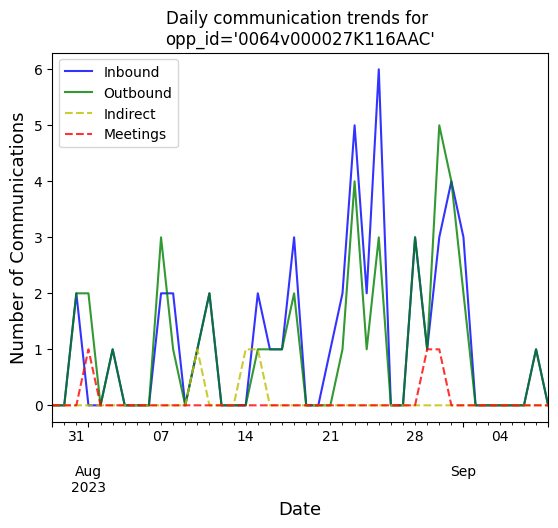

In [68]:
opp_id = '0064v000027K116AAC'

fig, ax = plt.subplots()
opp_df[opp_df.OpportunityId == opp_id].plot(
    x='CreatedDate', 
    y=['n__fc', 'n__tc', 'n__fo', 'n__me'], 
    xlabel='Date', 
    ylabel='Number of Communications', 
    style=['b-','g-','y--', 'r--'],
    alpha=0.8, 
    title=f'Daily communication trends for \n{opp_id=}', 
    ax=ax
)
ax.legend(['Inbound', 'Outbound', 'Indirect', 'Meetings'])
ax.set_xlabel(ax.get_xlabel(), fontsize=13)
ax.set_ylabel(ax.get_ylabel(), fontsize=13)
plt.show()

Text(0.5, 1.0, "Daily communication trends for \nopp_id='0064v000027K116AAC'")

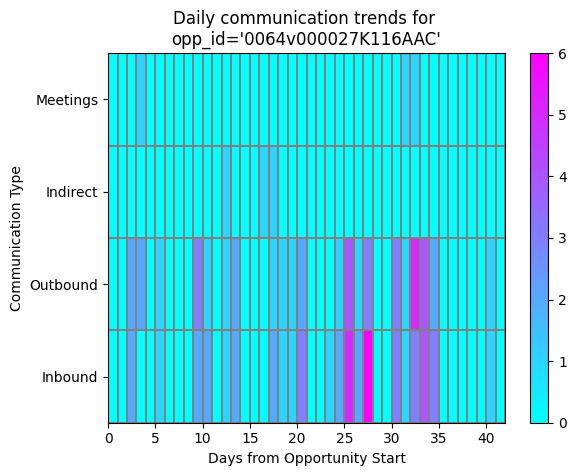

In [82]:
subset = opp_df[opp_df.OpportunityId == opp_id]
cols = ['n__fc', 'n__tc', 'n__fo', 'n__me']
ax = plt.pcolormesh(subset[cols].values.T, cmap='cool', linewidth=0.02, edgecolors='gray')
plt.colorbar(ax)
plt.yticks((0.5, 1.5, 2.5, 3.5), ['Inbound', 'Outbound', 'Indirect', 'Meetings'])
plt.xlabel("Days from Opportunity Start")
plt.ylabel("Communication Type")
plt.title(f'Daily communication trends for \n{opp_id=}')

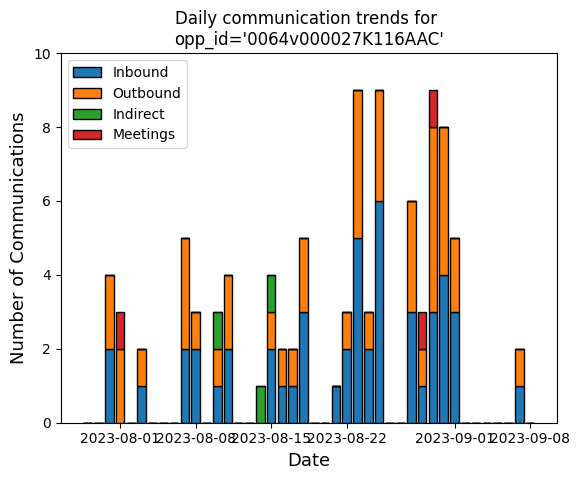

In [83]:
data = np.zeros(len(subset))
times = subset['CreatedDate']
for col, label in zip(cols, ['Inbound', 'Outbound', 'Indirect', 'Meetings']):
    plt.bar(times, subset[col].values, edgecolor='black', bottom=data, label=label)
    data += subset[col].values
plt.ylim((0, 10))
plt.xlabel('Date', fontsize=13)
plt.ylabel('Number of Communications', fontsize=13)
plt.title(f'Daily communication trends for \n{opp_id=}')
plt.legend()

## 3. Feature Engineering

The following code cell creates rolling window and expanding window features.

For the rolling window, we are looking at the sizes of 7, 30, and 90 days. This allows us to capture potential trends in opportunities of different sizes and nature. For communication duration, owner inclusion, and number of recipients, the totals AND averages within a window are found - in some cases, we might want to look at the total number of times an opportunity owner was included, while in other cases, the average would suffice. 

The rolling window features have the `__rw{N}` suffix where `{N}` designates the length of the window. 

The expanding window features are created in a similar way, except their "window" always has the size of the whole opportunity's duration up to the current point. Thus, as the opportunity progresses in time, the window becomes larger. 

The expanding window features have the `__x` suffix at the end.

In [64]:
# use to ignore performance warnings
import warnings
warnings.filterwarnings('ignore')

# rolling window parameters
window_sizes = [7, 30, 90]

# generate columns names for which rolling window features should be created
prefixes = ['n', 'duration_in', 'owner_included', 'n_recipients']
columns = []
for prefix in prefixes:
    for label in labels:
        columns.append(f"{prefix}__{label}")
print(columns)


for window in window_sizes:
    #print(f"{window=}")

    # obtain rolling-features data for all columns for a given window period. min_periods=0 means that no data is ommitted 
    groupbyrolling = opp_df.groupby('OpportunityId', as_index=False)[columns].rolling(window=window, closed='left', min_periods=0)
    for col in columns:
        #print(f"  {col=}")

        # get total within each window (sum)
        opp_df[f"{col}__rw{window}"] = groupbyrolling.sum()[col]

        # get averages for duration/owner_included/n_recipients in addition to totals
        if col.startswith('duration_in__') or col.startswith('owner_included__') or col.startswith('n_recipients__'):
            label = col[-2:]
            # add 1e-8 to the denominator to avoid ZeroDivisionError
            opp_df[f"mean_{col}__rw{window}"] = opp_df[f"{col}__rw{window}"] / (opp_df[f"n__{label}__rw{window}"] + 1e-8)
        

groupbyexpanding = opp_df.groupby('OpportunityId', as_index=False)[columns].expanding(1)
for col in columns:
    #print(f"{col=}")

    opp_df[f"{col}__x"] = groupbyexpanding.sum()[col].droplevel(0)

    if col.startswith('duration_in__') or col.startswith('owner_included__') or col.startswith('n_recipients__'):
        label = col[-2:]
        opp_df[f"mean_{col}__x"] = opp_df[f"{col}__x"] / (opp_df[f"n__{label}__x"] + 1e-8)


opp_df

['n__fc', 'n__tc', 'n__fo', 'n__me', 'duration_in__fc', 'duration_in__tc', 'duration_in__fo', 'duration_in__me', 'owner_included__fc', 'owner_included__tc', 'owner_included__fo', 'owner_included__me', 'n_recipients__fc', 'n_recipients__tc', 'n_recipients__fo', 'n_recipients__me']


,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,...,owner_included__me__x,mean_owner_included__me__x,n_recipients__fc__x,mean_n_recipients__fc__x,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x
0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.000000,3.0,1.000000,0.0,0.0,0.0,0.0
1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160306,0064v000024apA4AAI,2023-09-08,False,2023-09-07,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,103.0,5.421053,201.0,7.178571,36.0,36.0,28.0,28.0
160307,0064v000024b4LzAAI,2023-09-07,False,2023-09-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,40.0,10.000000,0.0,0.0,0.0,0.0
160308,0064v000027K116AAC,2023-09-08,False,2023-09-07,1.0,1.0,33.0,1.0,1.0,1.0,...,3.0,1.0,104.0,2.166667,85.0,2.023810,6.0,2.0,6.0,2.0
160309,0064v000024apA4AAI,2023-09-08,False,2023-09-08,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,103.0,5.421053,201.0,7.178571,36.0,36.0,28.0,28.0


The plot below shows 7-day window communication trends for a specific opportunity. Overall, the image is similar to the one above but looks smoother. There is still a relationship between inbound and outbound communications as their peak generally match, representing a consistent conversation.

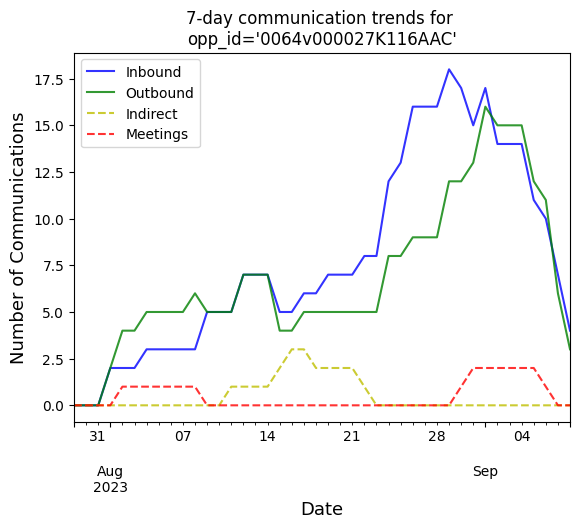

In [65]:
opp_id = '0064v000027K116AAC'

fig, ax = plt.subplots()
opp_df[opp_df.OpportunityId == opp_id].plot(
    x='CreatedDate', 
    y=['n__fc__rw7', 'n__tc__rw7', 'n__fo__rw7', 'n__me__rw7'], 
    xlabel='Date', 
    ylabel='Number of Communications', 
    style=['b-','g-','y--', 'r--'],
    alpha=0.8, 
    title=f'7-day communication trends for \n{opp_id=}', 
    ax=ax
)
ax.legend(['Inbound', 'Outbound', 'Indirect', 'Meetings'])
ax.set_xlabel(ax.get_xlabel(), fontsize=13)
ax.set_ylabel(ax.get_ylabel(), fontsize=13)
plt.show()


The next code cell generates a few more features and the target (outcome variable) for the dataset. 

More specifically `first_created_date` column is create to show when the opportunity was open for the first time. This will be used in the subsequent analysis. 

To define the target, we also find the fiscal quarters for the current states of the opportunity (based on `CreatedDate`) and its close date (based on `opp_esimated_close_date`). Fiscal quarters count starts from June in RevenueGrid. The target is considered positive (1) if an opportunity is won in a given fiscal quarter, and negative (0) otherwise. Therefore, each opportunity has only one state of target each of its lifetime's fiscal quarters.

In [15]:
# find the first time opportunity is created
opp_df['first_created_date'] = opp_df.groupby('OpportunityId')['CreatedDate'].transform('min')

# find fiscal quarters for the datetime features
opp_df.loc[:, 'CreatedDate__fq'] = pd.PeriodIndex(opp_df['CreatedDate'], freq='Q-JUN')
opp_df.loc[:, 'opp_estimated_close_date__fq'] = pd.PeriodIndex(opp_df['opp_estimated_close_date'], freq='Q-JUN')

opp_df['target'] = ((opp_df['IsWon']) & (opp_df['opp_estimated_close_date__fq'] == opp_df['CreatedDate__fq'])).astype(int)

opp_df.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,...,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0
1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q3,0
4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0


The below cell shows that only 5% of the opportunity-days represent positive outcomes.

In [16]:
opp_df.target.describe()

count    160311.000000
mean          0.050146
std           0.218247
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [17]:
opp_df.to_csv('dataset_rw.csv')